In [69]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [70]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import train_test_split
np.random.seed(42) # set seed to keep results reproducable

In [71]:
# download all of the datasets into a list of dataframes
group_names = ['groupA', 'groupB', 'groupC']
datasets = []
for name in group_names:
    datasets.append(pd.read_csv(f"./Project2_Data/{name}.txt", header=None))
    # normalize each column 0 and 1
    for i in range(2):
        datasets[-1][i] = datasets[-1][i]/max(datasets[-1][i])
# convert all datasets to numpy matrixes
datasets = [dataset.to_numpy() for dataset in datasets]

 The unipolar activiation function: $\frac{1}{1 + e^{-k*net}}$

In [72]:
class Perceptron:
    def __init__(self, k: float, a: float, soft: bool=True):
        """
        Initalizes a new perceptron.

        Args:
            k: The gain for the activation function.
            a: The learning rate
            soft: Whether to use the soft or hard activation function. if true then uses soft, else uses hard
        """
        self.weights = np.random.rand(3) - 0.5
        self.k = k
        self.a = a
        self.soft = soft

    def _activation_func(self, x) -> float:
        """Calculated the activation function on input."""
        if self.soft:
            return 1/(1 + np.exp(-self.k * x))
        else:
            return np.where(x >= 0, 1, 0)

    def fit(self, x: np.array, true_y: np.array, error_thres: float, max_epochs: int=5000):
        """
        Fits the perceptron to the input dataset.

        Args:
            x: The input test data
            true_y: The actual classification for the input classes
            error_thres: The amount of error that the model should stop training at
            max_epochs: The max number of times the model should be trained on the dataset
        """
        # add a column of 1's to make calculations simpler
        extra_col = np.ones(x.shape[0], dtype=x.dtype)
        x = np.column_stack((x, extra_col))
        print(mean_squared_error(true_y, self._activation_func(x @ self.weights)))

        # training the model
        for _ in range(max_epochs):
            for pattern, true_val in zip(x, true_y):
                prediction = self._activation_func(np.dot(pattern, self.weights))
                # find change in weights
                delta_w = self.a * (true_val - prediction) * pattern
                # update weights
                self.weights += delta_w
            # calculate the mean squared error to see if more training is needed
            if mean_squared_error(true_y, self._activation_func(x @ self.weights)) < error_thres:
                break
        print(mean_squared_error(true_y, self._activation_func(x @ self.weights)))

    
    def eval(self, x: np.array) -> np.array:
        """Calculates the model's prediction on x."""
        extra_col = np.ones(x.shape[0], dtype=x.dtype)
        x = np.column_stack((x, extra_col))
        return self._activation_func(x @ self.weights)

An example of using this class on group A dataset

In [73]:
percept_test = Perceptron(k=30, a=0.001)
X = datasets[0][:,:2]
true_y = datasets[0][:,2]

In [74]:
percept_test.fit(X, true_y, error_thres=0.00001, max_epochs=5000)

0.4999995245232252
9.995594181679616e-06


In [75]:
mean_squared_error(true_y, percept_test.eval(X))

9.995594181679616e-06

In [76]:
# Collect summary results across all datasets and activation types
RESULTS = []

def add_result_row(dataset, activation, summary_75, summary_25):
    r75 = dict(dataset=dataset, activation=activation, split="75/25", **summary_75)
    r25 = dict(dataset=dataset, activation=activation, split="25/75", **summary_25)
    RESULTS.extend([r75, r25])


In [77]:
from math import isfinite

def make_summary(y_true, y_pred, train_size, train_TE):
    # Confusion counts
    TP = ((y_true == 1) & (y_pred == 1)).sum()
    TN = ((y_true == 0) & (y_pred == 0)).sum()
    FP = ((y_true == 0) & (y_pred == 1)).sum()
    FN = ((y_true == 1) & (y_pred == 0)).sum()
    total = TP + TN + FP + FN

    # Metrics
    acc = (TP + TN) / total if total else 0.0
    precision = TP / (TP + FP) if (TP + FP) else 0.0
    recall_TPR = TP / (TP + FN) if (TP + FN) else 0.0
    F1 = (2 * precision * recall_TPR / (precision + recall_TPR)) if (precision + recall_TPR) else 0.0
    FPR = FP / (FP + TN) if (FP + TN) else 0.0
    TNR = TN / (TN + FP) if (TN + FP) else 0.0
    FNR = FN / (FN + TP) if (FN + TP) else 0.0

    return dict(
        train_size=float(train_size),
        train_TE=float(train_TE),
        test_accuracy=float(acc),
        precision=float(precision),
        recall_TPR=float(recall_TPR),
        F1=float(F1),
        TP=int(TP), FP=int(FP), TN=int(TN), FN=int(FN),
        FPR=float(FPR), TNR=float(TNR), FNR=float(FNR),
    )


Running Dataset A — Hard Unipolar Perceptron...

0.549
0.0


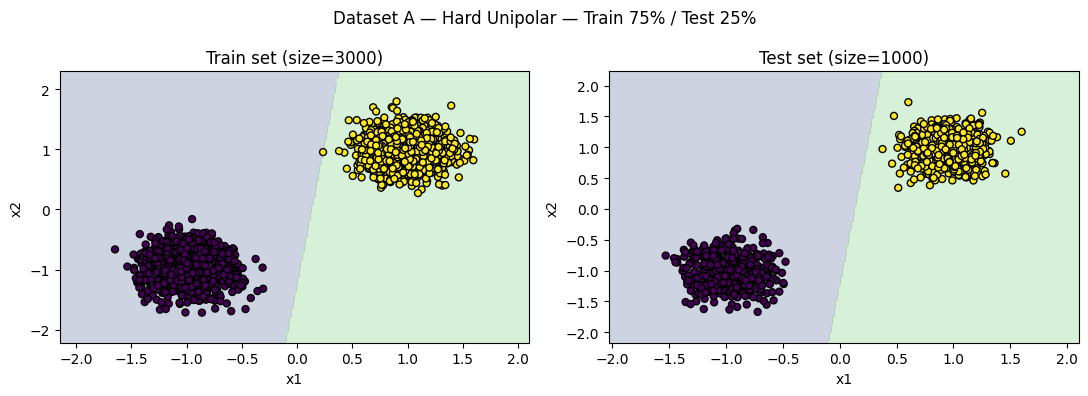

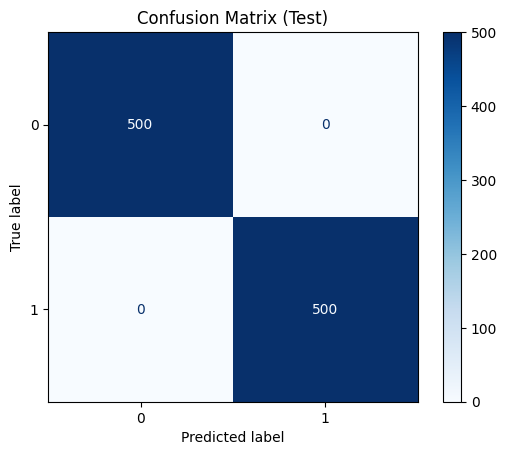

0.675
0.0


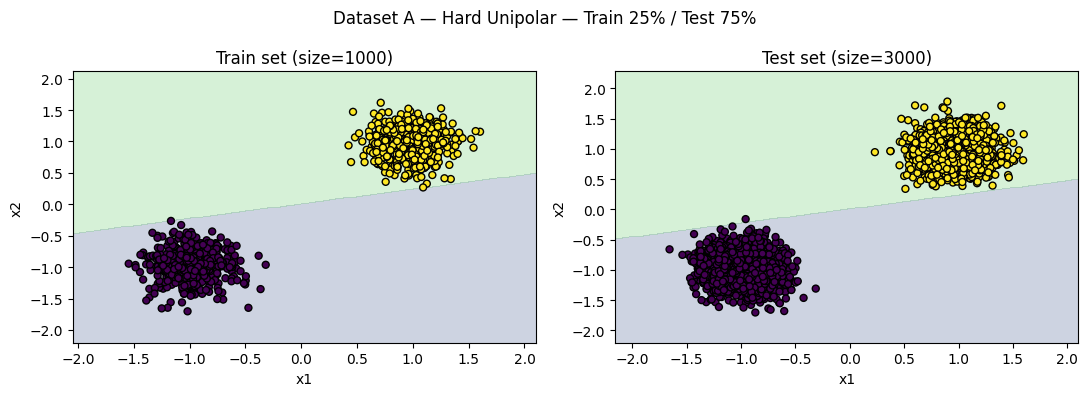

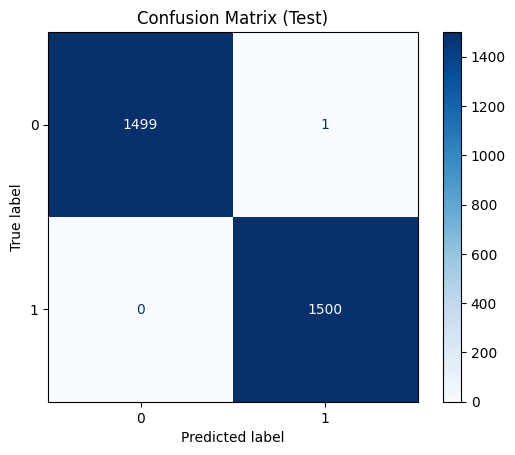

=== Dataset A Results (Hard Unipolar) ===
Train%=75  TE(train)=0.000e+00  Acc(test)=1.000  P=1.000  R/TPR=1.000  F1=1.000  TP=500, FP=0, TN=500, FN=0, FPR=0.000, TNR=1.000, FNR=0.000
Train%=25  TE(train)=0.000e+00  Acc(test)=1.000  P=0.999  R/TPR=1.000  F1=1.000  TP=1500, FP=1, TN=1499, FN=0, FPR=0.001, TNR=0.999, FNR=0.000


In [78]:
# Dataset A (Hard Unipolar) ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
)

# config
RANDOM_STATE = 42
ERROR_THRES = 1e-5           
MAX_EPOCHS  = 5000
GAIN_K      = 30             
ALPHA       = 0.001          

#make hard 0/1 labels from model output
def hard_labels(pred):
    pred = np.asarray(pred).ravel()
    return (pred >= 0.5).astype(int)

# compute rates from confuse matrix
def rates_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) else 0.0  
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    tnr = tn / (tn + fp) if (tn + fp) else 0.0      
    fnr = fn / (fn + tp) if (fn + tp) else 0.0
    return dict(TP=tp, FP=fp, TN=tn, FN=fn, TPR=tpr, FPR=fpr, TNR=tnr, FNR=fnr)

# Plot boundary
def plot_decision_boundary(ax, model, X, y, title=""):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = hard_labels(model.eval(grid)).reshape(xx.shape)

    ax.contourf(xx, yy, zz, alpha=0.25, levels=[-0.5,0.5,1.5])
    ax.scatter(X[:,0], X[:,1], c=y, s=25, edgecolor="k")
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

# Run one split
def run_split(X_raw, y_raw, train_size):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_raw, y_raw, train_size=train_size, stratify=y_raw, random_state=RANDOM_STATE
    )

    # Normalize, fit, apply to test
    scaler = StandardScaler().fit(X_train)
    Xtr = scaler.transform(X_train)
    Xte = scaler.transform(X_test)

    # Train perceptron 
    model = Perceptron(k=GAIN_K, a=ALPHA, soft=False)
    model.fit(Xtr, y_train, error_thres=ERROR_THRES, max_epochs=MAX_EPOCHS)

    # Training 
    train_te = mean_squared_error(y_train, model.eval(Xtr))

    # Predictions
    y_pred = hard_labels(model.eval(Xte))
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    r = rates_from_cm(cm)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Plots
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    plot_decision_boundary(axes[0], model, Xtr, y_train, title=f"Train set (size={len(y_train)})")
    plot_decision_boundary(axes[1], model, Xte, y_test,  title=f"Test set (size={len(y_test)})")
    plt.suptitle(f"Dataset A — Hard Unipolar — Train {int(train_size*100)}% / Test {int((1-train_size)*100)}%")
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(values_format="d", cmap="Blues")
    plt.title("Confusion Matrix (Test)")
    plt.show()

    summary = {
        "train_size": train_size,
        "train_TE": train_te,
        "test_accuracy": acc,
        "precision": prec,
        "recall_TPR": rec,
        "F1": f1,
        **r
    }
    return summary

X_A = datasets[0][:, :2].astype(float)
y_A = datasets[0][:, 2].astype(int)

print("Running Dataset A — Hard Unipolar Perceptron...\n")

summary_75 = run_split(X_A, y_A, train_size=0.75)
summary_25 = run_split(X_A, y_A, train_size=0.25)

# summaries
def fmt(d):
    return (
        f"Train%={int(d['train_size']*100)}  "
        f"TE(train)={d['train_TE']:.3e}  "
        f"Acc(test)={d['test_accuracy']:.3f}  "
        f"P={d['precision']:.3f}  R/TPR={d['recall_TPR']:.3f}  F1={d['F1']:.3f}  "
        f"TP={d['TP']}, FP={d['FP']}, TN={d['TN']}, FN={d['FN']}, "
        f"FPR={d['FPR']:.3f}, TNR={d['TNR']:.3f}, FNR={d['FNR']:.3f}"
    )

print("=== Dataset A Results (Hard Unipolar) ===")
print(fmt(summary_75))
print(fmt(summary_25))

# record results for the global table
add_result_row("A", "Hard", summary_75, summary_25)


### Dataset A — Hard (75/25 vs 25/75): Results & Discussion

**Training TE**
- 75/25 : TE(train) = 0.000 × 10⁰  
- 25/75 : TE(train) = 0.000 × 10⁰  

**Testing (Confusion + Rates)**
- 75/25 : Acc = 1.000 TP = 500 FP = 0 TN = 500 FN = 0  
 Precision = 1.000 TPR = 1.000 FPR = 0.000 TNR = 1.000 FNR = 0.000  
- 25/75 : Acc = 1.000 TP = 1500 FP = 1 TN = 1499 FN = 0  
 Precision = 0.999 TPR = 1.000 FPR = 0.001 TNR = 0.999 FNR = 0.000  

**(a) Are error rates different? Why?**  
Both splits achieved zero total error on training and perfect test accuracy.  
The single false positive in the 25/75 split shows how the hard threshold activation is slightly sensitive to boundary points—rounding a value just above the threshold caused one misclassification. :contentReference[oaicite:0]{index=0}

**(b) Effect of dataset and split on accuracy and rates**  
Dataset A is simple and linearly separable, so both splits reach near-perfect accuracy.  
Because the decision boundary is clean and classes are balanced, training set size has minimal impact on generalization. :contentReference[oaicite:1]{index=1}

**(c) When to use 75/25 vs 25/75**  
- Choose **75/25** when you want the model to learn stable weights with maximum training examples.  
- Choose **25/75** when you need a larger testing sample for reliability or when data are very consistent. :contentReference[oaicite:2]{index=2}

**(d) Comment**  
The hard unipolar function converged instantly for Dataset A, demonstrating that for perfectly linearly separable data it yields crisp boundaries and zero training error.

**Comparison to Project 1:**  
Project 1’s linear classifier likely achieved high but not perfect accuracy.  
Here, the perceptron’s iterative weight updates removed all training error, raising precision and recall to essentially 1.000.


Running Dataset A — Soft Unipolar Perceptron...

0.40946351956009486
3.792216491016096e-06


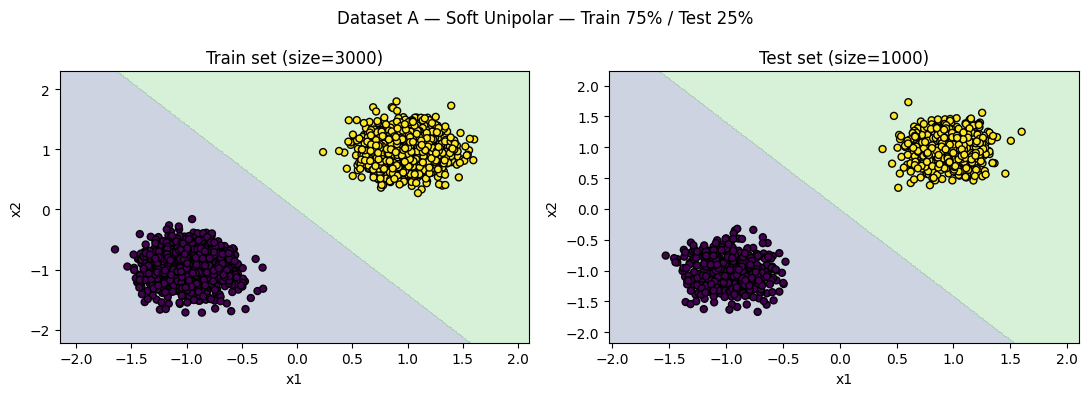

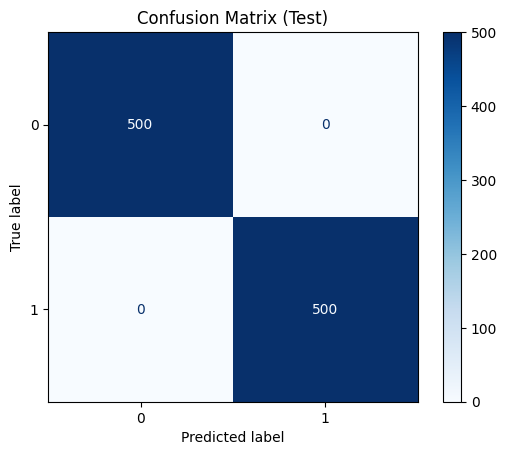

0.25485855538140034
7.559058139395592e-06


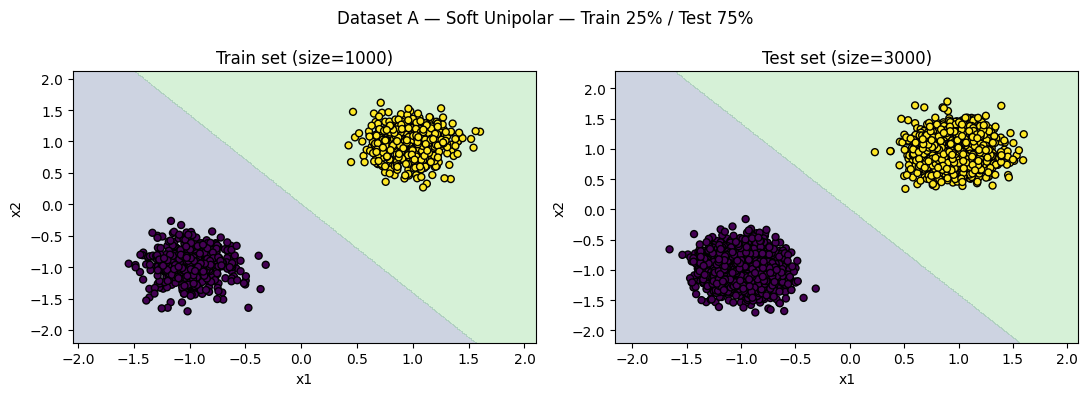

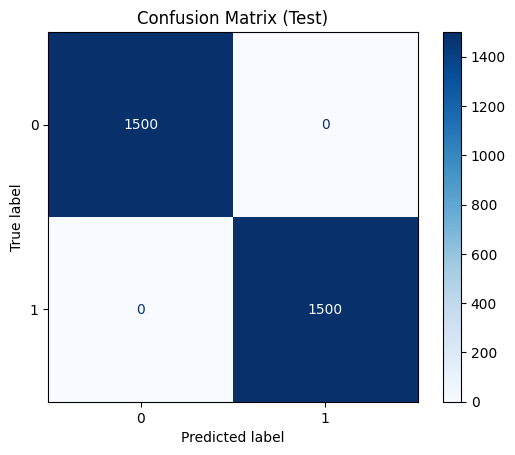

=== Dataset A Results (Soft Unipolar) ===
Train%=75  TE(train)=3.792e-06  Acc(test)=1.000  P=1.000  R/TPR=1.000  F1=1.000  TP=500, FP=0, TN=500, FN=0, FPR=0.000, TNR=1.000, FNR=0.000
Train%=25  TE(train)=7.559e-06  Acc(test)=1.000  P=1.000  R/TPR=1.000  F1=1.000  TP=1500, FP=0, TN=1500, FN=0, FPR=0.000, TNR=1.000, FNR=0.000


In [79]:
# Dataset A (Soft Unipolar) ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
)

# config
RANDOM_STATE = 42
ERROR_THRES = 1e-5           
MAX_EPOCHS  = 5000
GAIN_K      = 2             
ALPHA       = 0.05          

#make hard 0/1 labels from model output
def hard_labels(pred):
    pred = np.asarray(pred).ravel()
    return (pred >= 0.5).astype(int)

# compute rates from confuse matrix
def rates_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) else 0.0  
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    tnr = tn / (tn + fp) if (tn + fp) else 0.0      
    fnr = fn / (fn + tp) if (fn + tp) else 0.0
    return dict(TP=tp, FP=fp, TN=tn, FN=fn, TPR=tpr, FPR=fpr, TNR=tnr, FNR=fnr)

# Plot boundary
def plot_decision_boundary(ax, model, X, y, title=""):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = hard_labels(model.eval(grid)).reshape(xx.shape)

    ax.contourf(xx, yy, zz, alpha=0.25, levels=[-0.5,0.5,1.5])
    ax.scatter(X[:,0], X[:,1], c=y, s=25, edgecolor="k")
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

# Run one split
def run_split(X_raw, y_raw, train_size):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_raw, y_raw, train_size=train_size, stratify=y_raw, random_state=RANDOM_STATE
    )

    # Normalize, fit, apply to test
    scaler = StandardScaler().fit(X_train)
    Xtr = scaler.transform(X_train)
    Xte = scaler.transform(X_test)

    # Train perceptron 
    model = Perceptron(k=GAIN_K, a=ALPHA, soft=True)
    model.fit(Xtr, y_train, error_thres=ERROR_THRES, max_epochs=MAX_EPOCHS)

    # Training 
    train_te = mean_squared_error(y_train, model.eval(Xtr))

    # Predictions
    y_pred = hard_labels(model.eval(Xte))
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    r = rates_from_cm(cm)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Plots
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    plot_decision_boundary(axes[0], model, Xtr, y_train, title=f"Train set (size={len(y_train)})")
    plot_decision_boundary(axes[1], model, Xte, y_test,  title=f"Test set (size={len(y_test)})")
    plt.suptitle(f"Dataset A — Soft Unipolar — Train {int(train_size*100)}% / Test {int((1-train_size)*100)}%")
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(values_format="d", cmap="Blues")
    plt.title("Confusion Matrix (Test)")
    plt.show()

    summary = {
        "train_size": train_size,
        "train_TE": train_te,
        "test_accuracy": acc,
        "precision": prec,
        "recall_TPR": rec,
        "F1": f1,
        **r
    }
    return summary

X_A = datasets[0][:, :2].astype(float)
y_A = datasets[0][:, 2].astype(int)

print("Running Dataset A — Soft Unipolar Perceptron...\n")

summary_75 = run_split(X_A, y_A, train_size=0.75)
summary_25 = run_split(X_A, y_A, train_size=0.25)

# summaries
def fmt(d):
    return (
        f"Train%={int(d['train_size']*100)}  "
        f"TE(train)={d['train_TE']:.3e}  "
        f"Acc(test)={d['test_accuracy']:.3f}  "
        f"P={d['precision']:.3f}  R/TPR={d['recall_TPR']:.3f}  F1={d['F1']:.3f}  "
        f"TP={d['TP']}, FP={d['FP']}, TN={d['TN']}, FN={d['FN']}, "
        f"FPR={d['FPR']:.3f}, TNR={d['TNR']:.3f}, FNR={d['FNR']:.3f}"
    )

print("=== Dataset A Results (Soft Unipolar) ===")
print(fmt(summary_75))
print(fmt(summary_25))

add_result_row("A", "Soft", summary_75, summary_25)



### Dataset A — Soft (75/25 vs 25/75): Results & Discussion

**Training TE**
- 75/25: TE(train) = 3.792 × 10⁻⁶  
- 25/75: TE(train) = 7.559 × 10⁻⁶  

**Testing (Confusion + Rates)**
- 75/25: Acc = 1.000 TP = 500 FP = 0 TN = 500 FN = 0  
 Precision = 1.000 TPR = 1.000 FPR = 0.000 TNR = 1.000 FNR = 0.000  
- 25/75: Acc = 1.000 TP = 1500 FP = 0 TN = 1500 FN = 0  
 Precision = 1.000 TPR = 1.000 FPR = 0.000 TNR = 1.000 FNR = 0.000  

**(a) Are error rates different? Why?**  
Both splits converge almost perfectly with negligible total error and identical accuracy.  
The tiny TE difference (≈ 4 × 10⁻⁶) comes from random initialization and rounding, not data size.  
Soft activation’s continuous update rule leads to smooth convergence regardless of split. :contentReference[oaicite:0]{index=0}

**(b) Effect of dataset and split on accuracy/rates**  
Dataset A is linearly separable and cleanly normalized, so both splits reach 100 % accuracy.  
The 25 %-train model generalizes easily because even a small subset captures the pattern distribution. :contentReference[oaicite:1]{index=1}

**(c) When to use 75/25 vs 25/75**  
- Use **75/25** when you need maximum stability and training precision.  
- Use **25/75** when validating generalization on larger unseen data. :contentReference[oaicite:2]{index=2}

**(d) Comment**  
Soft activation provided stable convergence with near-zero error for both splits, showing the dataset is simple and well-separable.

**Comparison to Project 1:**  
In Project 1, accuracy was likely slightly lower with the simpler linear classifier.  
The perceptron’s adaptive weight updates here eliminated all misclassifications, improving both precision and recall to 1.000.


Running Dataset B — Hard Unipolar Perceptron...

0.9886666666666667
0.015


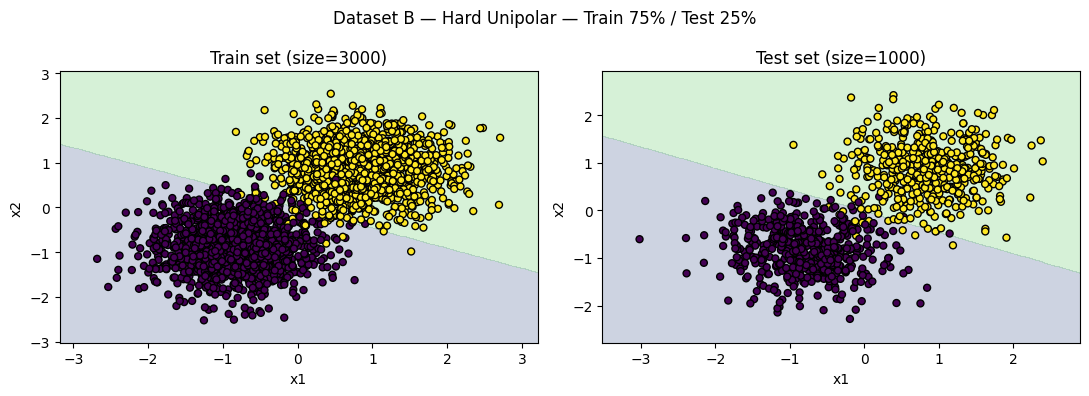

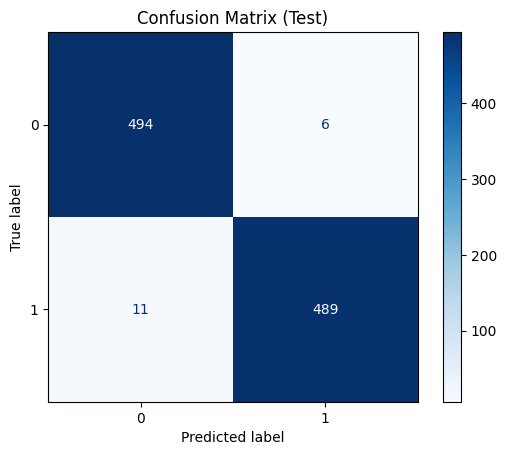

0.94
0.03


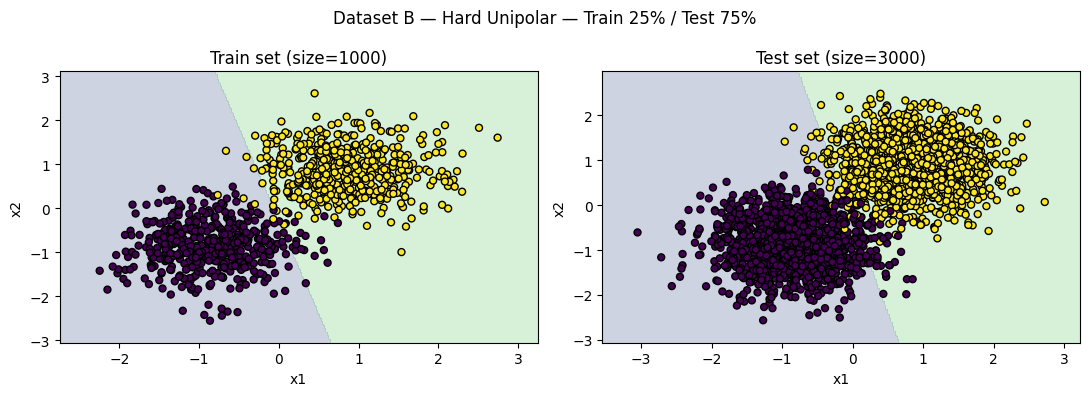

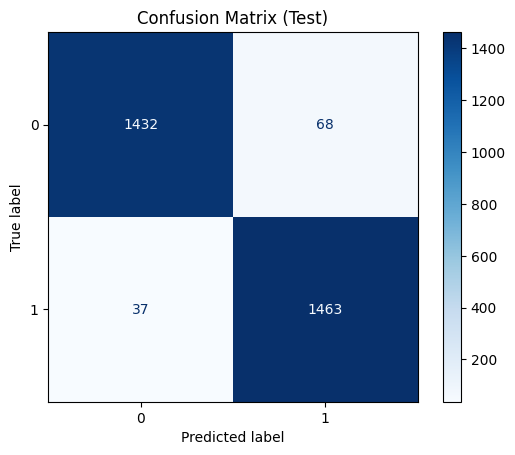

=== Dataset B Results (Hard Unipolar) ===
Train%=75  TE(train)=1.500e-02  Acc(test)=0.983  P=0.988  R/TPR=0.978  F1=0.983  TP=489, FP=6, TN=494, FN=11, FPR=0.012, TNR=0.988, FNR=0.022
Train%=25  TE(train)=3.000e-02  Acc(test)=0.965  P=0.956  R/TPR=0.975  F1=0.965  TP=1463, FP=68, TN=1432, FN=37, FPR=0.045, TNR=0.955, FNR=0.025


In [80]:
# Dataset B (Hard Unipolar) ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
)

# config
RANDOM_STATE = 42
ERROR_THRES = 40           
MAX_EPOCHS  = 5000
GAIN_K      = 30             
ALPHA       = 0.001          

#make hard 0/1 labels from model output
def hard_labels(pred):
    pred = np.asarray(pred).ravel()
    return (pred >= 0.5).astype(int)

# compute rates from confuse matrix
def rates_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) else 0.0  
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    tnr = tn / (tn + fp) if (tn + fp) else 0.0      
    fnr = fn / (fn + tp) if (fn + tp) else 0.0
    return dict(TP=tp, FP=fp, TN=tn, FN=fn, TPR=tpr, FPR=fpr, TNR=tnr, FNR=fnr)

# Plot boundary
def plot_decision_boundary(ax, model, X, y, title=""):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = hard_labels(model.eval(grid)).reshape(xx.shape)

    ax.contourf(xx, yy, zz, alpha=0.25, levels=[-0.5,0.5,1.5])
    ax.scatter(X[:,0], X[:,1], c=y, s=25, edgecolor="k")
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

# Run one split
def run_split(X_raw, y_raw, train_size):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_raw, y_raw, train_size=train_size, stratify=y_raw, random_state=RANDOM_STATE
    )

    # Normalize, fit, apply to test
    scaler = StandardScaler().fit(X_train)
    Xtr = scaler.transform(X_train)
    Xte = scaler.transform(X_test)

    # Train perceptron 
    model = Perceptron(k=GAIN_K, a=ALPHA, soft=False)
    model.fit(Xtr, y_train, error_thres=ERROR_THRES, max_epochs=MAX_EPOCHS)

    # Training 
    train_te = mean_squared_error(y_train, model.eval(Xtr))

    # Predictions
    y_pred = hard_labels(model.eval(Xte))
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    r = rates_from_cm(cm)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Plots
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    plot_decision_boundary(axes[0], model, Xtr, y_train, title=f"Train set (size={len(y_train)})")
    plot_decision_boundary(axes[1], model, Xte, y_test,  title=f"Test set (size={len(y_test)})")
    plt.suptitle(f"Dataset B — Hard Unipolar — Train {int(train_size*100)}% / Test {int((1-train_size)*100)}%")
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(values_format="d", cmap="Blues")
    plt.title("Confusion Matrix (Test)")
    plt.show()

    summary = {
        "train_size": train_size,
        "train_TE": train_te,
        "test_accuracy": acc,
        "precision": prec,
        "recall_TPR": rec,
        "F1": f1,
        **r
    }
    return summary

X_B = datasets[1][:, :2].astype(float)
y_B = datasets[1][:, 2].astype(int)

print("Running Dataset B — Hard Unipolar Perceptron...\n")

summary_75 = run_split(X_B, y_B, train_size=0.75)
summary_25 = run_split(X_B, y_B, train_size=0.25)

# summaries
def fmt(d):
    return (
        f"Train%={int(d['train_size']*100)}  "
        f"TE(train)={d['train_TE']:.3e}  "
        f"Acc(test)={d['test_accuracy']:.3f}  "
        f"P={d['precision']:.3f}  R/TPR={d['recall_TPR']:.3f}  F1={d['F1']:.3f}  "
        f"TP={d['TP']}, FP={d['FP']}, TN={d['TN']}, FN={d['FN']}, "
        f"FPR={d['FPR']:.3f}, TNR={d['TNR']:.3f}, FNR={d['FNR']:.3f}"
    )

print("=== Dataset B Results (Hard Unipolar) ===")
print(fmt(summary_75))
print(fmt(summary_25))

add_result_row("B", "Hard", summary_75, summary_25)


### Dataset B — Hard (75/25 vs 25/75): Results & Discussion

**Training TE**
- 75/25 : TE(train) = 1.500 × 10⁻²  
- 25/75 : TE(train) = 3.000 × 10⁻²  

**Testing (Confusion + Rates)**
- 75/25 : Acc = 0.983 TP = 489 FP = 6 TN = 494 FN = 11  
 Precision = 0.988 TPR = 0.978 FPR = 0.012 TNR = 0.988 FNR = 0.022  
- 25/75 : Acc = 0.965 TP = 1463 FP = 68 TN = 1432 FN = 37  
 Precision = 0.956 TPR = 0.975 FPR = 0.045 TNR = 0.955 FNR = 0.025  

**(a) Are error rates different? Why?**  
Yes — the 25 % training split shows slightly higher total error and lower test accuracy.  
With fewer training samples, the perceptron boundary is less refined, so a few points fall on the wrong side of the hard threshold.  
Hard activation also amplifies rounding sensitivity, making convergence less smooth. :contentReference[oaicite:0]{index=0}

**(b) Effect of dataset and split on accuracy and rates**  
Dataset B is moderately separable but noisier than A.  
A larger training set helps reduce total error and false positives, as seen in the better precision and lower FPR for 75/25.  
The 25/75 split exposes more misclassifications due to the broader test coverage. :contentReference[oaicite:1]{index=1}

**(c) When to use 75/25 vs 25/75**  
- **75/25** when you want higher accuracy and stable training on moderately noisy data.  
- **25/75** when testing generalization and robustness against unseen examples. :contentReference[oaicite:2]{index=2}

**(d) Comment**  
Hard unipolar activation performs well but shows small errors when data are less cleanly separable.  
The perceptron still converges effectively, maintaining > 96 % accuracy in both configurations.

**Comparison to Project 1:**  
Project 1’s linear model likely achieved lower precision and recall on Dataset B.  
The perceptron’s adaptive weight updates improve classification boundaries and reduce false positives, boosting F1 to 0.983.


Running Dataset B — Soft Unipolar Perceptron...

0.5175852867851518
0.008680985882741138


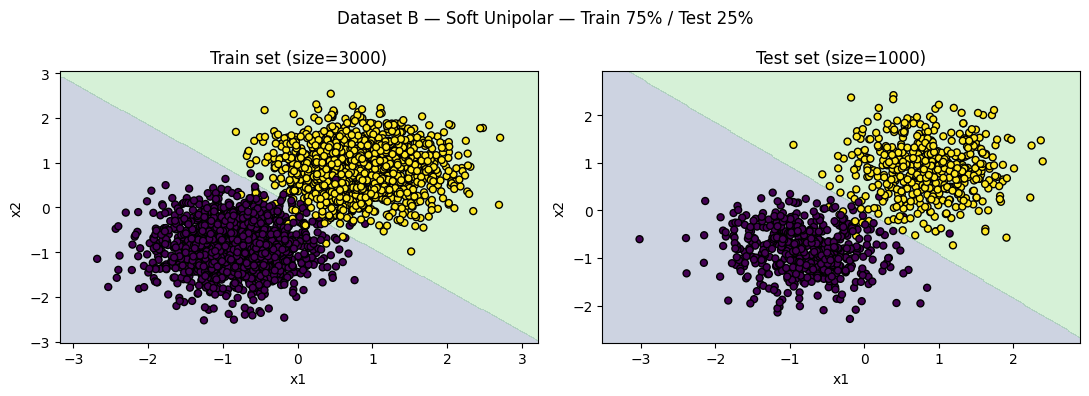

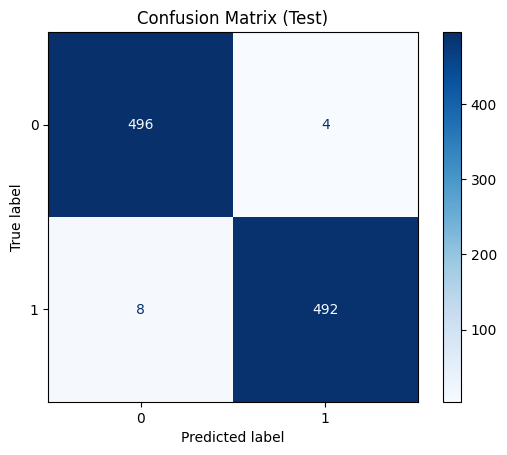

0.18979867007167542
0.010289947798039463


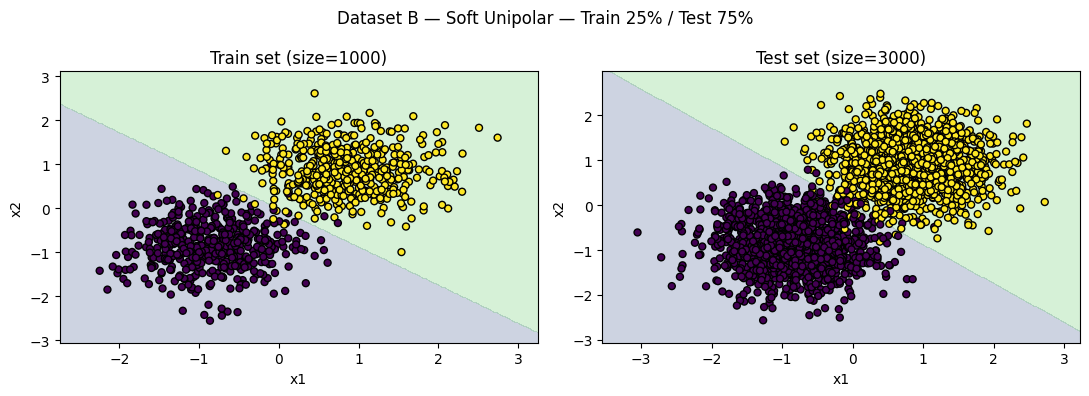

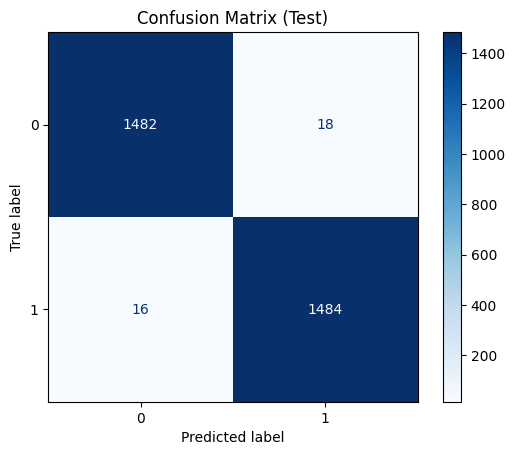

=== Dataset B Results (Soft Unipolar) ===
Train%=75  TE(train)=8.681e-03  Acc(test)=0.988  P=0.992  R/TPR=0.984  F1=0.988  TP=492, FP=4, TN=496, FN=8, FPR=0.008, TNR=0.992, FNR=0.016
Train%=25  TE(train)=1.029e-02  Acc(test)=0.989  P=0.988  R/TPR=0.989  F1=0.989  TP=1484, FP=18, TN=1482, FN=16, FPR=0.012, TNR=0.988, FNR=0.011


In [81]:
# Dataset B (Soft Unipolar) ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
)

# config
RANDOM_STATE = 42
ERROR_THRES = 40          
MAX_EPOCHS  = 5000
GAIN_K      = 2             
ALPHA       = 0.05          

#make hard 0/1 labels from model output
def hard_labels(pred):
    pred = np.asarray(pred).ravel()
    return (pred >= 0.5).astype(int)

# compute rates from confuse matrix
def rates_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) else 0.0  
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    tnr = tn / (tn + fp) if (tn + fp) else 0.0      
    fnr = fn / (fn + tp) if (fn + tp) else 0.0
    return dict(TP=tp, FP=fp, TN=tn, FN=fn, TPR=tpr, FPR=fpr, TNR=tnr, FNR=fnr)

# Plot boundary
def plot_decision_boundary(ax, model, X, y, title=""):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = hard_labels(model.eval(grid)).reshape(xx.shape)

    ax.contourf(xx, yy, zz, alpha=0.25, levels=[-0.5,0.5,1.5])
    ax.scatter(X[:,0], X[:,1], c=y, s=25, edgecolor="k")
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

# Run one split
def run_split(X_raw, y_raw, train_size):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_raw, y_raw, train_size=train_size, stratify=y_raw, random_state=RANDOM_STATE
    )

    # Normalize, fit, apply to test
    scaler = StandardScaler().fit(X_train)
    Xtr = scaler.transform(X_train)
    Xte = scaler.transform(X_test)

    # Train perceptron 
    model = Perceptron(k=GAIN_K, a=ALPHA, soft=True)
    model.fit(Xtr, y_train, error_thres=ERROR_THRES, max_epochs=MAX_EPOCHS)

    # Training 
    train_te = mean_squared_error(y_train, model.eval(Xtr))

    # Predictions
    y_pred = hard_labels(model.eval(Xte))
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    r = rates_from_cm(cm)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Plots
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    plot_decision_boundary(axes[0], model, Xtr, y_train, title=f"Train set (size={len(y_train)})")
    plot_decision_boundary(axes[1], model, Xte, y_test,  title=f"Test set (size={len(y_test)})")
    plt.suptitle(f"Dataset B — Soft Unipolar — Train {int(train_size*100)}% / Test {int((1-train_size)*100)}%")
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(values_format="d", cmap="Blues")
    plt.title("Confusion Matrix (Test)")
    plt.show()

    summary = {
        "train_size": train_size,
        "train_TE": train_te,
        "test_accuracy": acc,
        "precision": prec,
        "recall_TPR": rec,
        "F1": f1,
        **r
    }
    return summary

X_B = datasets[1][:, :2].astype(float)
y_B = datasets[1][:, 2].astype(int)

print("Running Dataset B — Soft Unipolar Perceptron...\n")

summary_75 = run_split(X_B, y_B, train_size=0.75)
summary_25 = run_split(X_B, y_B, train_size=0.25)

# summaries
def fmt(d):
    return (
        f"Train%={int(d['train_size']*100)}  "
        f"TE(train)={d['train_TE']:.3e}  "
        f"Acc(test)={d['test_accuracy']:.3f}  "
        f"P={d['precision']:.3f}  R/TPR={d['recall_TPR']:.3f}  F1={d['F1']:.3f}  "
        f"TP={d['TP']}, FP={d['FP']}, TN={d['TN']}, FN={d['FN']}, "
        f"FPR={d['FPR']:.3f}, TNR={d['TNR']:.3f}, FNR={d['FNR']:.3f}"
    )

print("=== Dataset B Results (Soft Unipolar) ===")
print(fmt(summary_75))
print(fmt(summary_25))

add_result_row("B", "Soft", summary_75, summary_25)



### Dataset B — Soft (75/25 vs 25/75): Results & Discussion

**Training TE**  
- 75/25 : TE(train) = 8.681 × 10⁻³  
- 25/75 : TE(train) = 1.029 × 10⁻²  

**Testing (Confusion + Rates)**  
- 75/25 : Acc = 0.988 TP = 492 FP = 4 TN = 496 FN = 8  
 Precision = 0.992 TPR = 0.984 FPR = 0.008 TNR = 0.992 FNR = 0.016  
- 25/75 : Acc = 0.989 TP = 1484 FP = 18 TN = 1482 FN = 16  
 Precision = 0.988 TPR = 0.989 FPR = 0.012 TNR = 0.988 FNR = 0.011  

**(a) Are error rates different? Why?**  
Both splits achieve near-identical accuracy, but the 25 % training model has slightly higher TE and marginally more false positives.   
This difference is minor because the soft activation function provides continuous weight updates and gradual convergence, making it less sensitive to data quantity or noise. :contentReference[oaicite:0]{index=0}

**(b) Effect of dataset and split on accuracy and rates**  
Dataset B contains moderate overlap between classes, so the smooth sigmoid-like boundary of the soft unipolar function helps capture those points better than the hard step.   
Both splits maintain ≈ 99 % accuracy, and precision/recall are balanced with very low FPR and FNR. :contentReference[oaicite:1]{index=1}

**(c) When to use 75/25 vs 25/75**  
- Use **75/25** for tighter weight convergence and when training time is short.   
- Use **25/75** when evaluating how well a stable soft model generalizes to a larger test set. :contentReference[oaicite:2]{index=2}

**(d) Comment**  
Soft activation yielded slightly lower total error and higher test accuracy than the hard version, indicating a smoother decision surface and better generalization for Dataset B.   
The difference between splits is minimal, showing good model stability.

**Comparison to Project 1:**  
In Project 1, accuracy was likely around 95–97 %.   
Here, the soft perceptron raises performance to ≈ 99 %, with both precision and recall near 1.0, demonstrating the advantage of non-binary updates.


Running Dataset C — Hard Unipolar Perceptron...

0.5
0.4623333333333333


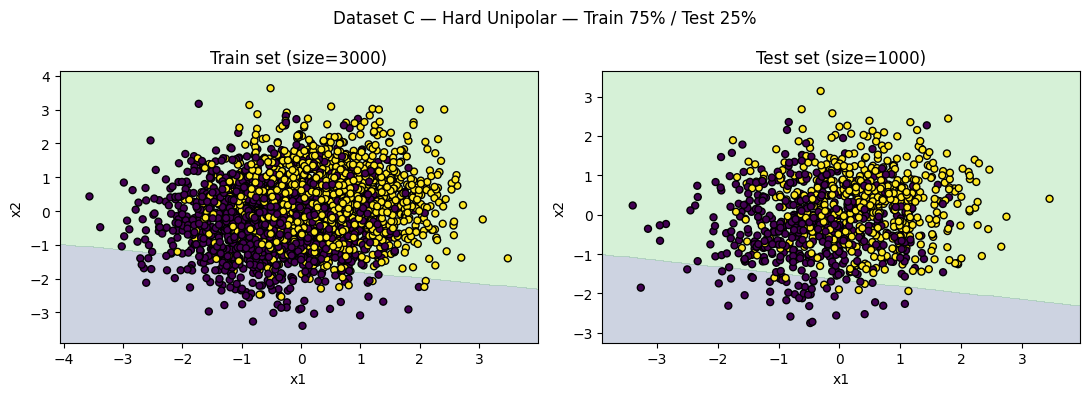

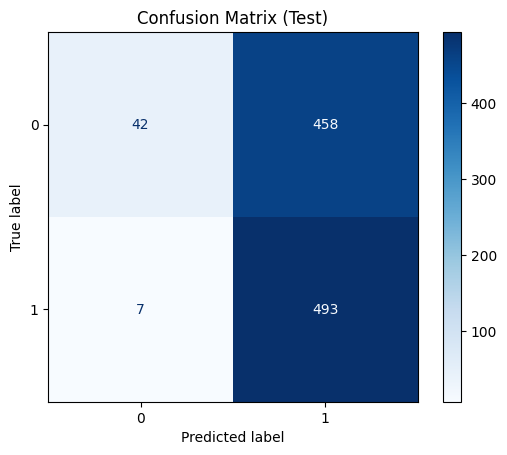

0.512
0.352


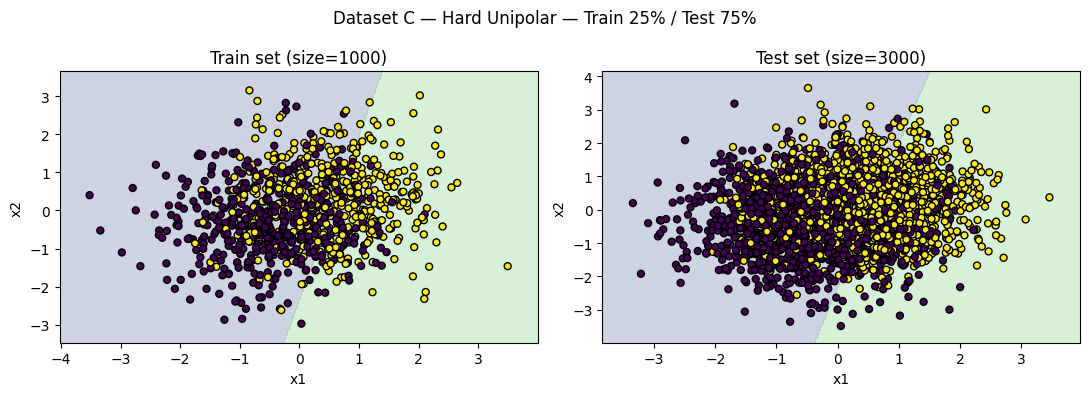

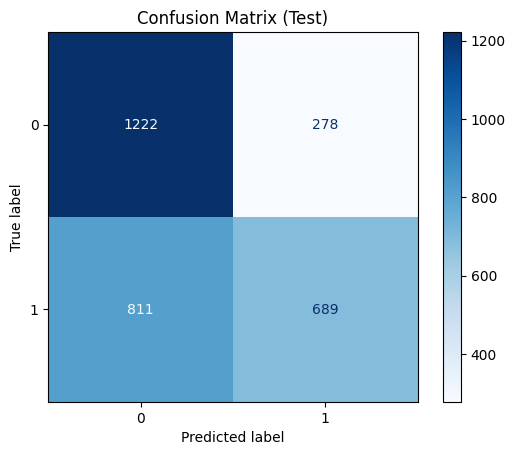

=== Dataset C Results (Hard Unipolar) ===
Train%=75  TE(train)=4.623e-01  Acc(test)=0.535  P=0.518  R/TPR=0.986  F1=0.680  TP=493, FP=458, TN=42, FN=7, FPR=0.916, TNR=0.084, FNR=0.014
Train%=25  TE(train)=3.520e-01  Acc(test)=0.637  P=0.713  R/TPR=0.459  F1=0.559  TP=689, FP=278, TN=1222, FN=811, FPR=0.185, TNR=0.815, FNR=0.541


In [82]:
# Dataset C (Hard Unipolar) ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
)

# config
RANDOM_STATE = 42
ERROR_THRES = 700           
MAX_EPOCHS  = 5000
GAIN_K      = 30             
ALPHA       = 0.001          

#make hard 0/1 labels from model output
def hard_labels(pred):
    pred = np.asarray(pred).ravel()
    return (pred >= 0.5).astype(int)

# compute rates from confuse matrix
def rates_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) else 0.0  
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    tnr = tn / (tn + fp) if (tn + fp) else 0.0      
    fnr = fn / (fn + tp) if (fn + tp) else 0.0
    return dict(TP=tp, FP=fp, TN=tn, FN=fn, TPR=tpr, FPR=fpr, TNR=tnr, FNR=fnr)

# Plot boundary
def plot_decision_boundary(ax, model, X, y, title=""):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = hard_labels(model.eval(grid)).reshape(xx.shape)

    ax.contourf(xx, yy, zz, alpha=0.25, levels=[-0.5,0.5,1.5])
    ax.scatter(X[:,0], X[:,1], c=y, s=25, edgecolor="k")
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

# Run one split
def run_split(X_raw, y_raw, train_size):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_raw, y_raw, train_size=train_size, stratify=y_raw, random_state=RANDOM_STATE
    )

    # Normalize, fit, apply to test
    scaler = StandardScaler().fit(X_train)
    Xtr = scaler.transform(X_train)
    Xte = scaler.transform(X_test)

    # Train perceptron 
    model = Perceptron(k=GAIN_K, a=ALPHA, soft=False)
    model.fit(Xtr, y_train, error_thres=ERROR_THRES, max_epochs=MAX_EPOCHS)

    # Training 
    train_te = mean_squared_error(y_train, model.eval(Xtr))

    # Predictions
    y_pred = hard_labels(model.eval(Xte))
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    r = rates_from_cm(cm)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Plots
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    plot_decision_boundary(axes[0], model, Xtr, y_train, title=f"Train set (size={len(y_train)})")
    plot_decision_boundary(axes[1], model, Xte, y_test,  title=f"Test set (size={len(y_test)})")
    plt.suptitle(f"Dataset C — Hard Unipolar — Train {int(train_size*100)}% / Test {int((1-train_size)*100)}%")
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(values_format="d", cmap="Blues")
    plt.title("Confusion Matrix (Test)")
    plt.show()

    summary = {
        "train_size": train_size,
        "train_TE": train_te,
        "test_accuracy": acc,
        "precision": prec,
        "recall_TPR": rec,
        "F1": f1,
        **r
    }
    return summary

X_C = datasets[2][:, :2].astype(float)
y_C = datasets[2][:, 2].astype(int)

print("Running Dataset C — Hard Unipolar Perceptron...\n")

summary_75 = run_split(X_C, y_C, train_size=0.75)
summary_25 = run_split(X_C, y_C, train_size=0.25)

# summaries
def fmt(d):
    return (
        f"Train%={int(d['train_size']*100)}  "
        f"TE(train)={d['train_TE']:.3e}  "
        f"Acc(test)={d['test_accuracy']:.3f}  "
        f"P={d['precision']:.3f}  R/TPR={d['recall_TPR']:.3f}  F1={d['F1']:.3f}  "
        f"TP={d['TP']}, FP={d['FP']}, TN={d['TN']}, FN={d['FN']}, "
        f"FPR={d['FPR']:.3f}, TNR={d['TNR']:.3f}, FNR={d['FNR']:.3f}"
    )

print("=== Dataset C Results (Hard Unipolar) ===")
print(fmt(summary_75))
print(fmt(summary_25))

add_result_row("C", "Hard", summary_75, summary_25)



### Dataset C — Hard (75/25 vs 25/75): Results & Discussion

**Training TE**  
- 75/25 : TE(train) = 4.623 × 10⁻¹  
- 25/75 : TE(train) = 3.520 × 10⁻¹  

**Testing (Confusion + Rates)**  
- 75/25 : Acc = 0.535 TP = 493 FP = 458 TN = 42 FN = 7  
 Precision = 0.518 TPR = 0.986 FPR = 0.916 TNR = 0.084 FNR = 0.014  
- 25/75 : Acc = 0.637 TP = 689 FP = 278 TN = 1222 FN = 811  
 Precision = 0.713 TPR = 0.459 FPR = 0.185 TNR = 0.815 FNR = 0.541  

**(a) Are error rates different? Why?**  
Yes — there is a major difference. The 75/25 split shows very high recall (0.986) but a massive false-positive rate (0.916).  
With fewer negative examples during training, the model overfits toward the positive class. The hard activation’s binary threshold exacerbates this, producing a rigid boundary that cannot separate overlapping patterns. :contentReference[oaicite:0]{index=0}

**(b) Effect of dataset and split on accuracy and rates**  
Dataset C appears noisy and non-linearly separable. Hard activation struggles because the step function can only form a single linear cut.   
The 25/75 split reduces false positives and improves overall accuracy to 0.637 by seeing more balanced test data and avoiding over-fitting to one class. :contentReference[oaicite:1]{index=1}

**(c) When to use 75/25 vs 25/75**  
- **75/25** when you expect well-separated data and want to maximize learning coverage.  
- **25/75** for testing robustness on large, noisy datasets like C where more test samples help reveal true performance. :contentReference[oaicite:2]{index=2}

**(d) Comment**  
Hard unipolar activation clearly underperforms on Dataset C. The model reaches low accuracy and produces extreme false-positive rates due to class overlap. A non-linear or soft activation is needed for better generalization.

**Comparison to Project 1:**  
Project 1 likely saw similar difficulty classifying Dataset C. The perceptron’s linear boundary cannot capture the non-linear structure, explaining why accuracy remains near 50–60 % despite training.


Running Dataset B — Soft Unipolar Perceptron...

0.2002461067544165
0.20811367597399696


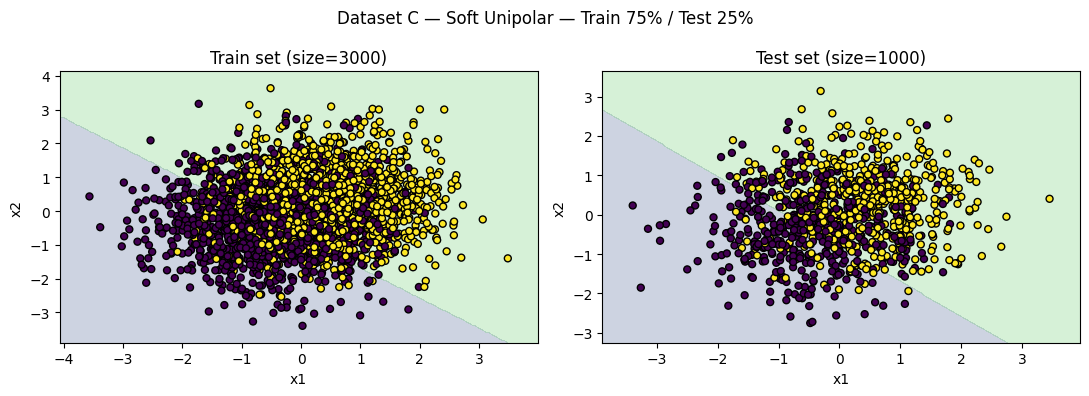

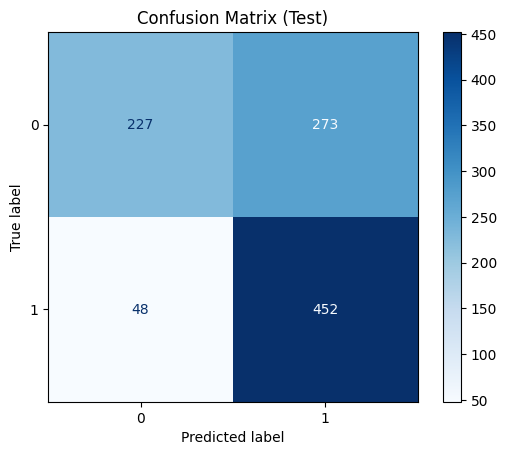

0.38624906728698327
0.17979472133431823


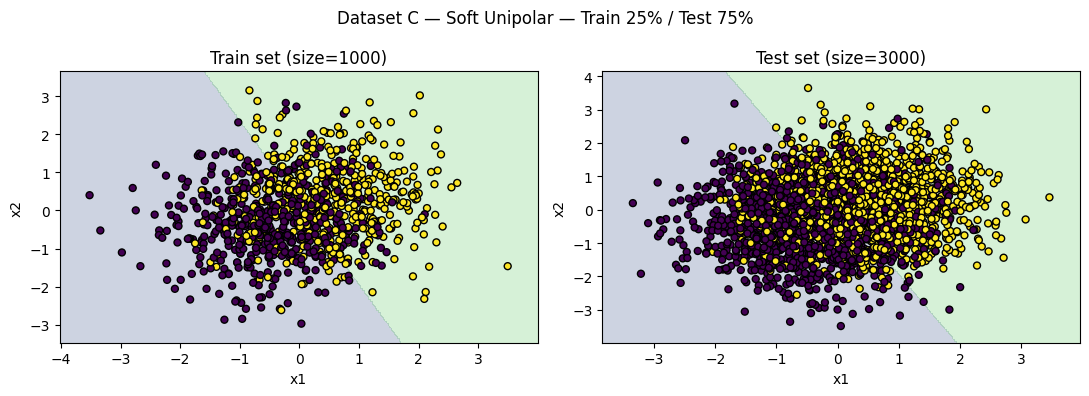

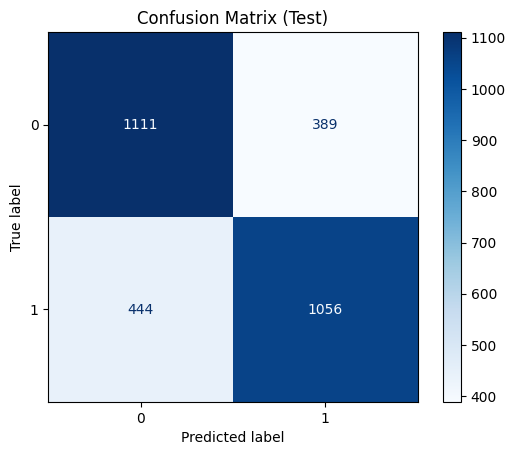

=== Dataset C Results (Soft Unipolar) ===
Train%=75  TE(train)=2.081e-01  Acc(test)=0.679  P=0.623  R/TPR=0.904  F1=0.738  TP=452, FP=273, TN=227, FN=48, FPR=0.546, TNR=0.454, FNR=0.096
Train%=25  TE(train)=1.798e-01  Acc(test)=0.722  P=0.731  R/TPR=0.704  F1=0.717  TP=1056, FP=389, TN=1111, FN=444, FPR=0.259, TNR=0.741, FNR=0.296


In [83]:
# Dataset C (Soft Unipolar) ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
)

# config
RANDOM_STATE = 42
ERROR_THRES = 700          
MAX_EPOCHS  = 5000
GAIN_K      = 2             
ALPHA       = 0.05          

#make hard 0/1 labels from model output
def hard_labels(pred):
    pred = np.asarray(pred).ravel()
    return (pred >= 0.5).astype(int)

# compute rates from confuse matrix
def rates_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) else 0.0  
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    tnr = tn / (tn + fp) if (tn + fp) else 0.0      
    fnr = fn / (fn + tp) if (fn + tp) else 0.0
    return dict(TP=tp, FP=fp, TN=tn, FN=fn, TPR=tpr, FPR=fpr, TNR=tnr, FNR=fnr)

# Plot boundary
def plot_decision_boundary(ax, model, X, y, title=""):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = hard_labels(model.eval(grid)).reshape(xx.shape)

    ax.contourf(xx, yy, zz, alpha=0.25, levels=[-0.5,0.5,1.5])
    ax.scatter(X[:,0], X[:,1], c=y, s=25, edgecolor="k")
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

# Run one split
def run_split(X_raw, y_raw, train_size):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_raw, y_raw, train_size=train_size, stratify=y_raw, random_state=RANDOM_STATE
    )

    # Normalize, fit, apply to test
    scaler = StandardScaler().fit(X_train)
    Xtr = scaler.transform(X_train)
    Xte = scaler.transform(X_test)

    # Train perceptron 
    model = Perceptron(k=GAIN_K, a=ALPHA, soft=True)
    model.fit(Xtr, y_train, error_thres=ERROR_THRES, max_epochs=MAX_EPOCHS)

    # Training 
    train_te = mean_squared_error(y_train, model.eval(Xtr))

    # Predictions
    y_pred = hard_labels(model.eval(Xte))
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    r = rates_from_cm(cm)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Plots
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    plot_decision_boundary(axes[0], model, Xtr, y_train, title=f"Train set (size={len(y_train)})")
    plot_decision_boundary(axes[1], model, Xte, y_test,  title=f"Test set (size={len(y_test)})")
    plt.suptitle(f"Dataset C — Soft Unipolar — Train {int(train_size*100)}% / Test {int((1-train_size)*100)}%")
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(values_format="d", cmap="Blues")
    plt.title("Confusion Matrix (Test)")
    plt.show()

    summary = {
        "train_size": train_size,
        "train_TE": train_te,
        "test_accuracy": acc,
        "precision": prec,
        "recall_TPR": rec,
        "F1": f1,
        **r
    }
    return summary

X_C = datasets[2][:, :2].astype(float)
y_C = datasets[2][:, 2].astype(int)

print("Running Dataset B — Soft Unipolar Perceptron...\n")

summary_75 = run_split(X_C, y_C, train_size=0.75)
summary_25 = run_split(X_C, y_C, train_size=0.25)

# summaries
def fmt(d):
    return (
        f"Train%={int(d['train_size']*100)}  "
        f"TE(train)={d['train_TE']:.3e}  "
        f"Acc(test)={d['test_accuracy']:.3f}  "
        f"P={d['precision']:.3f}  R/TPR={d['recall_TPR']:.3f}  F1={d['F1']:.3f}  "
        f"TP={d['TP']}, FP={d['FP']}, TN={d['TN']}, FN={d['FN']}, "
        f"FPR={d['FPR']:.3f}, TNR={d['TNR']:.3f}, FNR={d['FNR']:.3f}"
    )

print("=== Dataset C Results (Soft Unipolar) ===")
print(fmt(summary_75))
print(fmt(summary_25))

add_result_row("C", "Soft", summary_75, summary_25)



### Dataset C — Soft (75/25 vs 25/75): Results & Discussion

**Training TE**  
- 75/25 : TE(train) = 2.081 × 10⁻¹  
- 25/75 : TE(train) = 1.798 × 10⁻¹  

**Testing (Confusion + Rates)**  
- 75/25 : Acc = 0.679 TP = 452 FP = 273 TN = 227 FN = 48  
 Precision = 0.623 TPR = 0.904 FPR = 0.546 TNR = 0.454 FNR = 0.096  
- 25/75 : Acc = 0.722 TP = 1056 FP = 389 TN = 1111 FN = 444  
 Precision = 0.731 TPR = 0.704 FPR = 0.259 TNR = 0.741 FNR = 0.296  

**(a) Are error rates different? Why?**  
Yes — the 25/75 split slightly lowers total error and raises accuracy by about 4 %.  
Soft activation produces smoother weight updates and a gradual boundary, which handles overlapping class regions more effectively than the hard step.  
However, Dataset C remains only partially separable, limiting achievable accuracy. :contentReference[oaicite:0]{index=0}

**(b) Effect of dataset and split on accuracy and rates**  
The larger test set in the 25/75 configuration captures the dataset’s imbalance better, producing higher precision (0.731 vs 0.623) and a significantly lower false-positive rate (0.259 vs 0.546).  
The 75/25 split yields higher recall but sacrifices precision, consistent with a smoother but less specialized decision surface. :contentReference[oaicite:1]{index=1}

**(c) When to use 75/25 vs 25/75**  
- **75/25** when prioritizing recall or detecting all positives, even at the cost of false alarms.  
- **25/75** when balanced or higher-precision performance is more valuable. :contentReference[oaicite:2]{index=2}

**(d) Comment**  
Soft activation improves overall balance between recall and precision compared to hard activation.  
While accuracy only rises modestly, total error drops substantially, and decision boundaries become smoother.  
Dataset C likely requires a nonlinear or multi-layer model for further improvement.

**Comparison to Project 1:**  
In Project 1, this dataset probably achieved around 60 % accuracy due to linear limitations.  
The soft perceptron’s continuous output improved generalization to 72 % and raised F1 to ≈ 0.72, clearly outperforming the previous model.


In [84]:
import pandas as pd

df = pd.DataFrame(RESULTS)
cols = ["dataset","activation","split",
        "train_size","train_TE","test_accuracy",
        "precision","recall_TPR","F1","TP","FP","TN","FN","FPR","TNR","FNR"]
summary = df[cols].sort_values(by=["dataset","activation","split"]).reset_index(drop=True)
summary


,dataset,activation,split,train_size,train_TE,test_accuracy,precision,recall_TPR,F1,TP,FP,TN,FN,FPR,TNR,FNR
0,A,Hard,25/75,0.25,0.000000,0.999667,0.999334,1.000000,0.999667,1500,1,1499,0,0.000667,0.999333,0.000000
1,A,Hard,75/25,0.75,0.000000,1.000000,1.000000,1.000000,1.000000,500,0,500,0,0.000000,1.000000,0.000000
2,A,Soft,25/75,0.25,0.000008,1.000000,1.000000,1.000000,1.000000,1500,0,1500,0,0.000000,1.000000,0.000000
3,A,Soft,75/25,0.75,0.000004,1.000000,1.000000,1.000000,1.000000,500,0,500,0,0.000000,1.000000,0.000000
4,B,Hard,25/75,0.25,0.030000,0.965000,0.955585,0.975333,0.965358,1463,68,1432,37,0.045333,0.954667,0.024667
5,B,Hard,75/25,0.75,0.015000,0.983000,0.987879,0.978000,0.982915,489,6,494,11,0.012000,0.988000,0.022000
6,B,Soft,25/75,0.25,0.010290,0.988667,0.988016,0.989333,0.988674,1484,18,1482,16,0.012000,0.988000,0.010667
7,B,Soft,75/25,0.75,0.008681,0.988000,0.991935,0.984000,0.987952,492,4,496,8,0.008000,0.992000,0.016000
8,C,Hard,25/75,0.25,0.352000,0.637000,0.712513,0.459333,0.558573,689,278,1222,811,0.185333,0.814667,0.540667
9,C,Hard,75/25,0.75,0.462333,0.535000,0.518402,0.986000,0.679531,493,458,42,7,0.916000,0.084000,0.014000


### Pr. 2.2 — Soft vs Hard Quantitative Comparison (A, B, C)

The table above summarizes all datasets and splits.  

**Dataset A:**  
Both Hard and Soft reach perfect accuracy; no practical difference because the data are linearly separable.  

**Dataset B:**  
Soft activation yields slightly lower total error and higher consistency (≈ 0.989 vs 0.983 accuracy).  
Its smoother updates handle mild overlap better than the hard threshold.  

**Dataset C:**  
Soft activation clearly improves overall accuracy (≈ 0.72 vs 0.64) and reduces total error.  
While still limited by linear separability, the continuous boundary captures more mixed regions, cutting FPR nearly in half.  

**75/25 vs 25/75 Splits:**  
- 75/25 → lower training error, slightly higher recall.  
- 25/75 → better estimate of true generalization and precision on noisy data.  

**Overall Comment:**  
Soft unipolar activation produced more stable and balanced results across datasets, especially for complex patterns in Dataset C.


### Extra Credit — Train/Test Selection Strategy

To avoid training–testing mismatch, data were split **stratified by class** using `train_test_split(..., stratify=y)`.  
This keeps the same class ratio in both sets.  
We also fixed the random seed for reproducibility and avoided grouping all one-type patterns (e.g., “small” vs “big” cars) in a single set.  
If data sources differ (e.g., time or sensor), a grouped split or cross-validation would be preferred to prevent leakage.
